# Step 3 - Model Selection

We started from the work done in the preprocessing. We have fixed the number of dimensions to be used with the reduction to 150, this seemed a good compromise between speed and variance explanation (see preprocessing notebook). <br>
For computational ease we reduce the usage of the dataset to a little fraction, the entire dataset will be used to predict the "unseen" data later. <br>
To proceed with the exercise we need to do the preprocessing again, so we put it here in one piece of code:


In [19]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:2000,:]
del df_complete

five_stars = df['overall']

df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))
    
from gensim import corpora, models, matutils
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined

# removing stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop

# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique

# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

del documents_no_stop_no_unique_no_numeric

import enchant
eng_dic = enchant.Dict("en_US")

# remove non-english words
documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

del documents_no_stop_no_unique_no_numeric_lemmatize

# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)

# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

from sklearn.model_selection import train_test_split
train_tfidf, test_tfidf, train_category, test_category = train_test_split(sparse_corpus_tfidf_transpose,\
                                                                          df.ix[:,1], test_size = 0.2, random_state = seed)

print('Starting dimensionality reduction')

# reduce dimensions
from sklearn.decomposition import KernelPCA

reducer= KernelPCA(n_components = 150, kernel="cosine", random_state=seed)
corpus_train_tfidf_kpca = reducer.fit_transform(train_tfidf)
corpus_test_tfidf_kpca = reducer.transform(test_tfidf)

print('Finished dimensionality reduction')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Dictionary(6780 unique tokens: ['hard', 'believe', 'memory', 'tree', 'came']...)
Starting dimensionality reduction
Finished dimensionality reduction


As we have already mentioned, managing imbalanced classes has been the biggest problem in steps 2 and 3. The first approach has been the one of changing scoring function because mean accuracy can be misleading in these situations. Therefore we developed our own scoring method computing the average absolute error in assigning the overall score to the comment. We define it in the following code and it will be used for both the 'GridSearchCV' and the model evaluation against the test data.

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

def our_scoring_function(y_true,y_pred):
    penalties=np.zeros([5,5])
    for i in np.arange(5):
        for j in np.arange(5):
            penalties[i,j]= -np.abs(i-j)
    conf_mat = confusion_matrix(y_true, y_pred,labels=np.arange(1,6))/np.shape(y_true)[0]
    return np.sum(penalties*conf_mat)
    

from sklearn.metrics import make_scorer
our_scoring= make_scorer(our_scoring_function)

# This part is just to show how the scoring function work, the steps are slightly changed, in this way it is easier
# to understand.
print('This matrix assigns a greater penalty the greater was the mis-classification:')
penalties=np.zeros([5,5])
for i in np.arange(5):
    for j in np.arange(5):
        penalties[i,j]= -np.abs(i-j)
print(penalties.astype(int))

y_true=np.array([1,2,2,3,4,5,1,4])
y_pred=np.array([1,2,4,3,1,5,1,3])

print('\nSuppose that we wanted to assess the following:')
print('y_true: ',y_true)
print('y_pred: ',y_pred)

print('\nWe compute the confusion matrix of the prediction:')
print(confusion_matrix(y_true, y_pred,labels=np.arange(1,6)).astype(int))

print('\nThe two matrixes are multiplied element-wise to assess the goodness of the prediction:')
print((penalties*confusion_matrix(y_true, y_pred,labels=np.arange(1,6))).astype(int))

print('\nFinally, we summed the elements of the previous matrix and divided by the number of predictions.\n\
In this way we could compare our results for test stes of different sizes.\
\nThe resulting score will be negative in general and equal to one only in the case of a perfect prediction.\n\
For this demo it was: ', our_scoring_function(y_true,y_pred))

This matrix assigns a greater penalty the greater was the mis-classification:
[[ 0 -1 -2 -3 -4]
 [-1  0 -1 -2 -3]
 [-2 -1  0 -1 -2]
 [-3 -2 -1  0 -1]
 [-4 -3 -2 -1  0]]

Suppose that we wanted to assess the following:
y_true:  [1 2 2 3 4 5 1 4]
y_pred:  [1 2 4 3 1 5 1 3]

We compute the confusion matrix of the prediction:
[[2 0 0 0 0]
 [0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 1 0 0]
 [0 0 0 0 1]]

The two matrixes are multiplied element-wise to assess the goodness of the prediction:
[[ 0  0  0  0  0]
 [ 0  0  0 -2  0]
 [ 0  0  0  0  0]
 [-3  0 -1  0  0]
 [ 0  0  0  0  0]]

Finally, we summed the elements of the previous matrix and divided by the number of predictions.
In this way we could compare our results for test stes of different sizes.
The resulting score will be negative in general and equal to one only in the case of a perfect prediction.
For this demo it was:  -0.75


Changing the scoring function will influence the choice of hopefully better hyperparameters, the presence of imbalanced classes will still push some models to always predict 5 stars though. We thought a lot on how to deal with this issue, a possible solution could have been an undersample (oversample) of the train set to reduce this imbalance. It is implemented in the following lines.

In [21]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler=RandomUnderSampler(ratio=0.1,random_state=seed)
X_train_undersample, y_train_undersample = under_sampler.fit_sample(corpus_train_tfidf_kpca, train_category)

In this way we removed part of the imbalance by reducing the ratio of the most numerous label (5-stars) vs least numerous (1-star) to a maximum of 10:1. By doing that indeed the models started to predict different labels more often, but their performance in the test set was greatly reduced. The decision tree and bagging models were the best using this strategy, but when we increased the size of the train set they became slower and the logistic regression had better results.<br>
We did some research and found that several methods - especially the parametric models that we used - are already implemented with some corrections against imbalanced data. Indeed, once the train size was big enough, the logistic regression would as usual outperform all the others in both cases.<br>

To achieve the best results we should have had used a training set with the same balance as the test set, however we have no idea about the distribution of the unseen data. In other situations we might have come up with some educated guesses, but here there was no way to find it so we just supposed that it was the same of the data we were given. As a conclusion we decided not to undersample our train set.

In [22]:
from sklearn.dummy import DummyClassifier

X_train = corpus_train_tfidf_kpca 
X_test = corpus_test_tfidf_kpca
y_train = train_category
y_test = test_category

dummy_clf = DummyClassifier(strategy='stratified', random_state = seed)
dummy_clf.fit(X_train, y_train)
score_dummy=our_scoring_function(y_test,dummy_clf.predict(X_test))

print('Dummy Classifier Test Performance:', score_dummy)

Dummy Classifier Test Performance: -0.832917705736


The dummy classifier will be our benchmark, with mean absolute error of 0.83. Now it is the time of KNN, the data did not look as well divided as in the first step so we did not expect a good performance.

Starting Grid Search


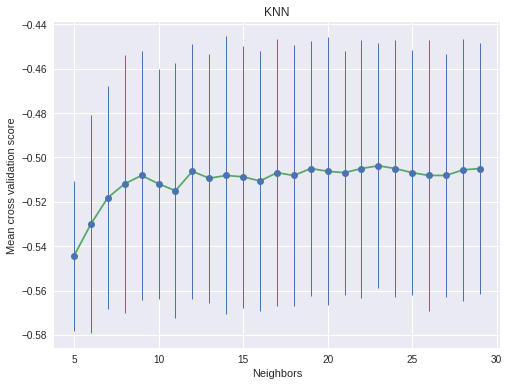

Best Number of Neighbors: 23

Test score for KNN: -0.518703241895


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

#Initialize K-Fold for cross validation
K = 5
kfold = KFold(n_splits=K, random_state=seed)

#Create Pipeline
estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('knn_clf', KNeighborsClassifier()))
reg_knn_pipe1 = Pipeline(estimators)
reg_knn_pipe1.set_params(knn_clf__algorithm='ball_tree',knn_clf__weights='uniform')

#Create a grid search over n_neighbors values
parameters = {
        'knn_clf__n_neighbors' : np.arange(5,30)
}
estimator_knnreg = GridSearchCV(reg_knn_pipe1, parameters,scoring=our_scoring, cv=kfold)
                  
#Evaluate the grid search and print best regressor
print('Starting Grid Search')
estimator_knnreg.fit(X_train, y_train)

alphas = [x['knn_clf__n_neighbors'] for x in estimator_knnreg.cv_results_['params']]
means = [x for x in estimator_knnreg.cv_results_['mean_test_score']]
stds = [x for x in estimator_knnreg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('Neighbors')
plt.ylabel('Mean cross validation score')
plt.title('KNN')
plt.show()

reg_knn_pipe1.set_params(knn_clf__n_neighbors = estimator_knnreg.best_params_['knn_clf__n_neighbors'])
reg_knn_pipe1.fit(X_train, y_train)

print("Best Number of Neighbors:", estimator_knnreg.best_params_['knn_clf__n_neighbors'])
score_KNN=our_scoring_function(y_test,reg_knn_pipe1.predict(X_test))
print ('\nTest score for KNN:', score_KNN)

It was better than the dummy classifier but when we increased the number of observations its learning curve was quite flat. Now it is the turn of the decision trees.

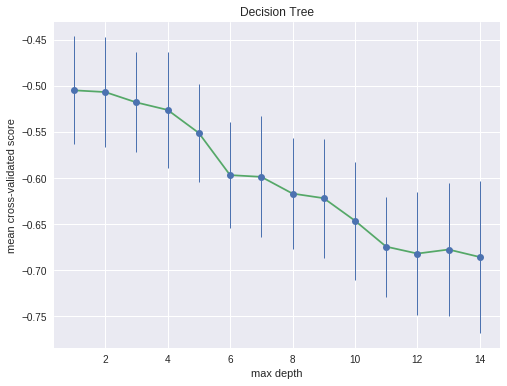


Best max depth --->    1

Test score for basic decision tree --->    -0.518703241895


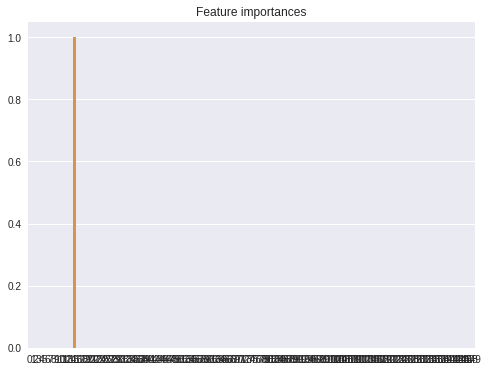


Bagging Test score --->    -0.518703241895


In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import seaborn as sns


n_tried=15
depths=np.arange(1,n_tried)

estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('tree_cla', tree.DecisionTreeClassifier(random_state=seed)))
cla_tree_pipe1 = Pipeline(estimators)

parameters = {
        'tree_cla__max_depth' : depths
}
estimator_treecla = GridSearchCV(cla_tree_pipe1, parameters,scoring=our_scoring, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_treecla.fit(X_train, y_train)

alphas = [x['tree_cla__max_depth'] for x in estimator_treecla.cv_results_['params']]
means = [x for x in estimator_treecla.cv_results_['mean_test_score']]
stds = [x for x in estimator_treecla.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('max depth')
plt.ylabel('mean cross-validated score')
plt.title('Decision Tree')
plt.show()

print('\nBest max depth --->   ',estimator_treecla.best_params_['tree_cla__max_depth'])

cla_tree_pipe1.set_params(tree_cla__max_depth = estimator_treecla.best_params_['tree_cla__max_depth'])
cla_tree_pipe1.fit(X_train, y_train)
score_tree=our_scoring_function(y_test,cla_tree_pipe1.predict(X_test))
print ('\nTest score for basic decision tree --->   ', score_tree)
importances = cla_tree_pipe1.named_steps['tree_cla'].feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
sns.barplot(indices, y=importances[indices])
plt.show()


estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('bag_cla', BaggingClassifier()))
cla_bag_pipe1 = Pipeline(estimators)
cla_bag_pipe1.set_params(bag_cla__base_estimator=tree.DecisionTreeClassifier(max_depth=estimator_treecla.best_params_['tree_cla__max_depth']),\
                         bag_cla__n_estimators=500, bag_cla__random_state=seed)

cla_bag_pipe1.fit(X_train,y_train)
score_bagging=our_scoring_function(y_test,cla_bag_pipe1.predict(X_test))
print ('\nBagging Test score --->   ', score_bagging)

As we had anticipated the performance of these models is heavily influenced by the balance of the data. It is also evident that they are not using all the information provided (we plotted the 'feature importances'). That might explain the better performance of parametric methods.

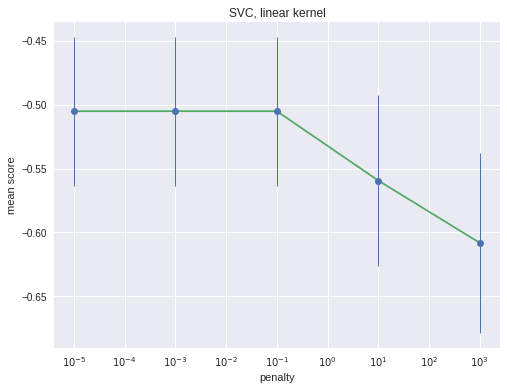


Best penalty for linear kernel --->    1e-05

Linear kernel test score --->    -0.518703241895


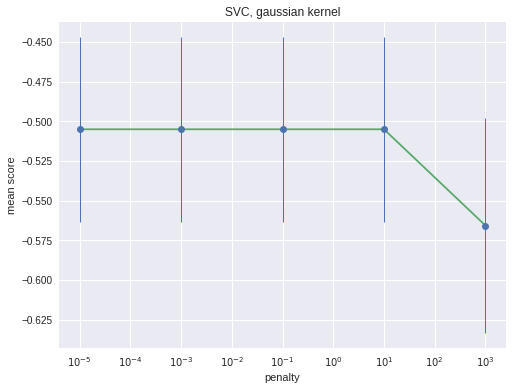


Best penalty for Gaussian kernel --->    1e-05

Test score --->    -0.518703241895


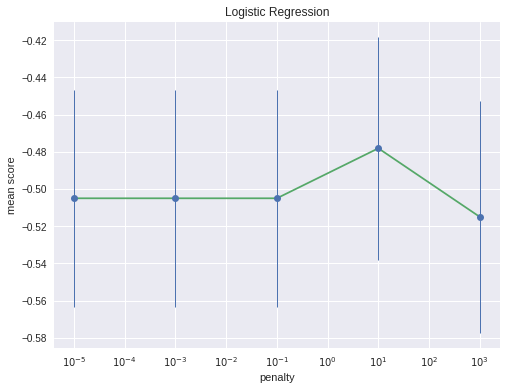


Best penalty for Logistic Regression --->    10.0

Logistic regression test score --->    -0.483790523691


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
                  

# LINEAR KERNEL
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('svm_linear_clf', SVC()))
svm_linear_pipe1 = Pipeline(estimators)
svm_linear_pipe1.set_params(svm_linear_clf__kernel='linear', svm_linear_clf__gamma='auto')

penalties = np.logspace(-5,3,5)


parameters = {
        'svm_linear_clf__C' : penalties
}
estimator_svm_linear = GridSearchCV(svm_linear_pipe1, parameters,scoring=our_scoring, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_svm_linear.fit(X_train,y_train)

alphas = [x['svm_linear_clf__C'] for x in estimator_svm_linear.cv_results_['params']]
means = [x for x in estimator_svm_linear.cv_results_['mean_test_score']]
stds = [x for x in estimator_svm_linear.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean score')
plt.title('SVC, linear kernel')
plt.xscale('log')
plt.show()

print('\nBest penalty for linear kernel --->   ',estimator_svm_linear.best_params_['svm_linear_clf__C'])

svm_linear_pipe1.set_params(svm_linear_clf__C = estimator_svm_linear.best_params_['svm_linear_clf__C'])
svm_linear_pipe1.fit(X_train,y_train)
score_linearSVM=our_scoring_function(y_test,svm_linear_pipe1.predict(X_test))
print ('\nLinear kernel test score --->   ', score_linearSVM)


# GAUSSIAN KERNEL
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('svm_gaussian_clf', SVC()))
svm_gaussian_pipe1 = Pipeline(estimators)
#No gridsearch on gamma, since 'auto' gave best results
svm_gaussian_pipe1.set_params(svm_gaussian_clf__kernel='rbf', svm_gaussian_clf__gamma='auto')

penalties = np.logspace(-5,3,5)


parameters = {
        'svm_gaussian_clf__C' : penalties
}
estimator_svm_gaussian = GridSearchCV(svm_gaussian_pipe1, parameters,scoring=our_scoring, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_svm_gaussian.fit(X_train,y_train)

alphas = [x['svm_gaussian_clf__C'] for x in estimator_svm_gaussian.cv_results_['params']]
means = [x for x in estimator_svm_gaussian.cv_results_['mean_test_score']]
stds = [x for x in estimator_svm_gaussian.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean score')
plt.title('SVC, gaussian kernel')
plt.xscale('log')
plt.show()

print('\nBest penalty for Gaussian kernel --->   ',estimator_svm_gaussian.best_params_['svm_gaussian_clf__C'])

svm_gaussian_pipe1.set_params(svm_gaussian_clf__C = estimator_svm_gaussian.best_params_['svm_gaussian_clf__C'])
svm_gaussian_pipe1.fit(X_train,y_train)
score_gaussianSVM=our_scoring_function(y_test,svm_gaussian_pipe1.predict(X_test))
print ('\nTest score --->   ', score_gaussianSVM)



# LOGISTIC REGRESSION
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('log_reg', LogisticRegression()))
log_reg_pipe1 = Pipeline(estimators)

penalties = np.logspace(-5,3,5)


parameters = {
        'log_reg__C' : penalties
}
estimator_log_reg = GridSearchCV(log_reg_pipe1, parameters,scoring=our_scoring, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_log_reg.fit(X_train,y_train)

alphas = [x['log_reg__C'] for x in estimator_log_reg.cv_results_['params']]
means = [x for x in estimator_log_reg.cv_results_['mean_test_score']]
stds = [x for x in estimator_log_reg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean score')
plt.title('Logistic Regression')
plt.xscale('log')
plt.show()

print('\nBest penalty for Logistic Regression --->   ',estimator_log_reg.best_params_['log_reg__C'])

log_reg_pipe1.set_params(log_reg__C = 1)
log_reg_pipe1.fit(X_train,y_train)
score_logreg=our_scoring_function(y_test,log_reg_pipe1.predict(X_test))
print ('\nLogistic regression test score --->   ', score_logreg)

The performance of these methods is not extraordinary, nor much higher than the others. As in the previous steps though, by increasing the size of the training set the learning curve of the logistic regression is steeper and it remains computationally feasible.

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Dictionary(17899 unique tokens: ['hard', 'believe', 'memory', 'tree', 'came']...)
Finished Preprocessing
Computing Learning Curve


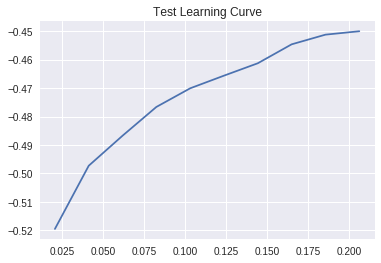

In [28]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:20000,:]
del df_complete

five_stars = df['overall']

df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))
    
from gensim import corpora, models, matutils
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined

# removing stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop

# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique

# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

del documents_no_stop_no_unique_no_numeric

import enchant
eng_dic = enchant.Dict("en_US")

# remove non-english words
documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

del documents_no_stop_no_unique_no_numeric_lemmatize

# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)

# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

print("Finished Preprocessing")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

%matplotlib inline

#Initialize Logistic Regression
log_reg = LogisticRegression(C=3.6)


#Compute and Plot learning curve
print("Computing Learning Curve")
train_sizes, train_scores, test_scores = learning_curve(log_reg, sparse_corpus_tfidf_transpose, df.ix[:,1]\
                                                        ,scoring=our_scoring, train_sizes = np.linspace(0.1,1,10), cv=3)

plt.plot(train_sizes/64706, test_scores.mean(axis=1))
plt.title("Test Learning Curve")

As anticipated, the more the better...

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Dictionary(10449 unique tokens: ['hard', 'believe', 'memory', 'tree', 'came']...)


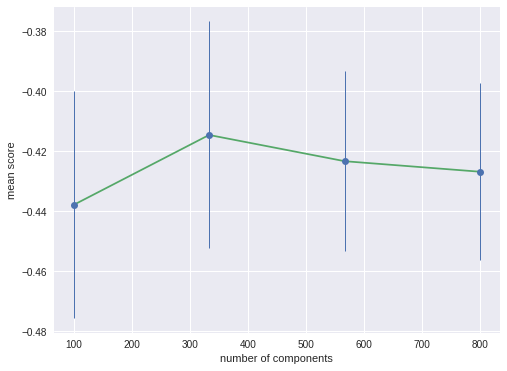


Best number of components --->    333.0

Logistic regression test score --->    -0.468531468531


In [30]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:5000,:]
del df_complete

five_stars = df['overall']

df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))
    
from gensim import corpora, models, matutils
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined

# removing stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop

# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique

# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

del documents_no_stop_no_unique_no_numeric

import enchant
eng_dic = enchant.Dict("en_US")

# remove non-english words
documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

del documents_no_stop_no_unique_no_numeric_lemmatize

# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)

# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sparse_corpus_tfidf_transpose, df.ix[:,1], test_size = 0.2, random_state = seed)

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

def our_scoring_function(y_true,y_pred):
    penalties=np.zeros([5,5])
    for i in np.arange(5):
        for j in np.arange(5):
            penalties[i,j]= -np.abs(i-j)
    conf_mat = confusion_matrix(y_true, y_pred,labels=np.arange(1,6))/np.shape(y_true)[0]
    return np.sum(penalties*conf_mat)
    

from sklearn.metrics import make_scorer
our_scoring= make_scorer(our_scoring_function)


#Initialize K-Fold for cross validation
K = 5
kfold = KFold(n_splits=K, random_state=seed)


# LOGISTIC REGRESSION
estimators = []
estimators.append(('reducer', KernelPCA(kernel="cosine", random_state=seed)))
estimators.append(('normalizer', Normalizer()))
estimators.append(('log_reg', LogisticRegression(C=3.6)))
log_reg_pipe1 = Pipeline(estimators)
log_reg_pipe1.set_params()

components = np.round(np.linspace(100,800,4))


parameters = {
        'reducer__n_components' : components
}
estimator_log_reg = GridSearchCV(log_reg_pipe1, parameters,scoring=our_scoring, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_log_reg.fit(X_train,y_train)

alphas = [x['reducer__n_components'] for x in estimator_log_reg.cv_results_['params']]
means = [x for x in estimator_log_reg.cv_results_['mean_test_score']]
stds = [x for x in estimator_log_reg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('number of components')
plt.ylabel('mean score')
plt.show()

print('\nBest number of components --->   ',estimator_log_reg.best_params_['reducer__n_components'])

log_reg_pipe1.set_params(log_reg__C = 3.6)
log_reg_pipe1.fit(X_train,y_train)
score_logreg=our_scoring_function(y_test,log_reg_pipe1.predict(X_test))
print ('\nLogistic regression test score --->   ', score_logreg)

We met the same problem of step one, we had to choose between more data and dimensionality reduction. Once again we opted for more data. As a conclusion we decided once again to use the logistic regression to predict the final values. We had also considered ensemble voting methods but they were too slow and the learning curve effect allowed the logistic regression to outerform them.